# Example of an RV analysis including a GP treatment of stellar activity

The following is an example of how I typically approach modelling an RV time series that is known to contain at least one planetary signal and stellar activity. The intention is two illustrate the steps that I taken to go from the input time series to physical models of planetary signals and a probabilistic model of stellar activity in the form of a 1d Gaussian process. Hopefully you find the instructions herein useful if you are new to RV data analysis.

In this example we'll consider the published data of the two-planet system around the nearby M dwarf K2-18 (https://arxiv.org/abs/1707.04292). Let's begin by first reading in the HARPS RV time series and visualizing the data and its Bayesian generalized Lomb-Scargle (BGLS) periodogram to identify significant periodicities in the data.

In [262]:
import numpy as np
import matplotlib.pyplot as plt
import george, emcee, bgls, time, warnings, corner
from scipy.signal import medfilt        # median filter
from scipy.interpolate import interp1d  # 1d interpolation
%matplotlib inline

In [244]:
# read in HARPs time series
d = np.loadtxt('./input_data/2M1130+0735_05052017_w7s5c5_NAIRA_v1.rdb', skiprows=2)
bjd, rv, erv = d[:,:3].T   # only read in the RV time series and its uncertainties
bjd += 2.4e6   # convert to barycentric julian date
rv *= 1e3      # km/s -> m/s
erv *= 1e3     # km/s -> m/s

First we should inspect the RVs themselves for the sake of transparency.

Text(0,0.5,u'RV [m/s]')

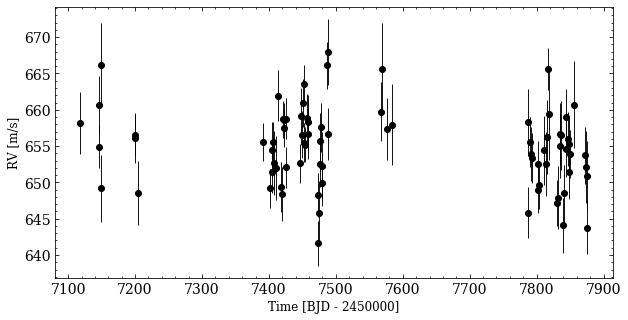

In [245]:
# visualize RVs
global t0
t0 = 245e4
plt.figure(figsize=(10,5))
plt.errorbar(bjd-t0, rv, erv, fmt='ko', elinewidth=.9)
plt.xlabel('Time [BJD - %i]'%t0, fontsize=12)
plt.ylabel('RV [m/s]', fontsize=12)

So the RVs look reasonable in that there are no obvious outliers. Furthermore, we can see that the star was observed by HARPS over three distinct observing windows.

Next let's plot the BGLS periodogram and highlight the periodic signal from the known transiting planet K2-18b at $\sim$ 33 days.

In [246]:
Pb, T0b = 32.93963, 2456836.1849   # period and mid-transit time of the transiting planet from the K2 light curve
per, pwr = bgls.bgls(bjd, rv, erv, plow=.5, phigh=1e3, n_steps=1e3)

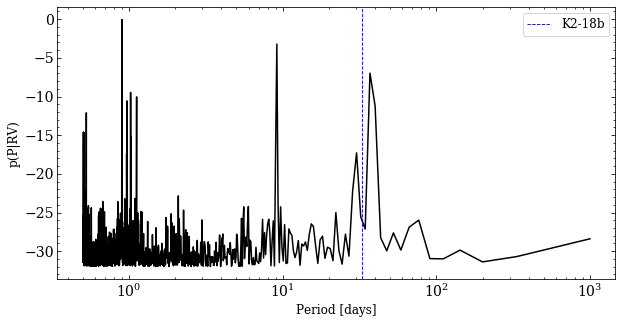

In [247]:
# plot the BGLS
plt.figure(figsize=(10,5))
plt.plot(per, np.log(pwr), 'k-')
plt.axvline(Pb, ls='--', lw=.9, color='b', label='K2-18b')
plt.xscale('log'), plt.xlabel('Period [days]', fontsize=12)
plt.ylabel('p(P|RV)', fontsize=12)
plt.legend(loc='upper right', fontsize=12)

We can see a number of significant peaks in the BGLS periodogram. The least interesting ones are the aliases close to 1 day and half a day that are always present in RV time series and results from the fact that the instrument is on a the ground and is rotating relative to the distant stars with a period of 1 day (the signal at half a day is the first harmonic of 1 day).

The more interesting signals are<br>

1) a strong peak at 9 days which is likely due to a non-transiting in this system and<br>
2) a pair of peaks surrounding the transiting planet's orbit period of 33 days.<br>

It turns out that the joint peaks around 33 days may also be attributed to stellar rotation as well as to the RV signal from the known transiting planet. Let's confirm this by considering the star's K2 light curve.

## consider the K2-18 photometry of K2-18

Specifically the cleaned K2 photometry from the EVEREST light curve extraction pipeline (https://archive.stsci.edu/prepds/everest/).

In [248]:
# read in the cleaned K2 photometry from the EVEREST pipeline
bjdK2, flux, eflux = np.load('input_data/k218_k2_photometry.npy').T
bjdK2 += 2454833  # convert the barycentric julian date

In [249]:
# isolate points in and out of transit (this is done by eye)
transit_indices = np.append(np.arange(1201,1207), np.arange(2602,2610))
intransit = np.in1d(np.arange(bjdK2.size), transit_indices)
outtransit = np.invert(intransit)

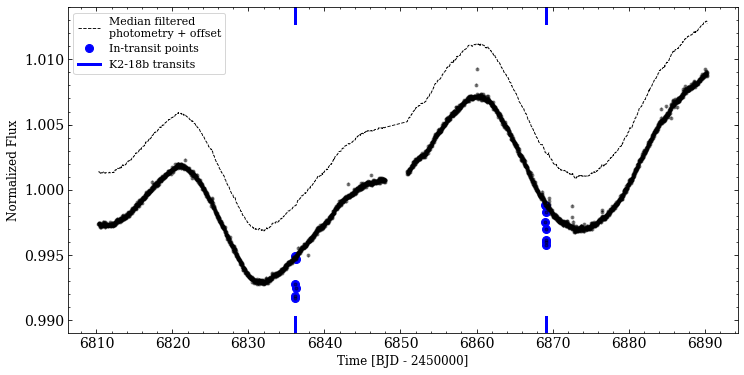

In [250]:
# visualize the light curve and highlight the transits
plt.figure(figsize=(12,6))
plt.errorbar(bjdK2-t0, flux, eflux, fmt='k.', elinewidth=.9, alpha=.4)
plt.plot(bjdK2[outtransit]-t0, medfilt(flux[outtransit],9)+4e-3, 'k--', lw=.9, 
         label='Median filtered\nphotometry + offset')
plt.plot(bjdK2[intransit]-t0, flux[intransit], 'bo', ms=8, label='In-transit points')
for i in range(2):
    plt.axvline(T0b+i*Pb-t0, ls='-', lw=3, color='b', ymax=.05, label='K2-18b transits')
    plt.axvline(T0b+i*Pb-t0, ls='-', lw=3, color='b', ymin=.95)
plt.ylim((.989,1.014))
plt.xlabel('Time [BJD - %i]'%t0, fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
plt.legend(loc='upper left', fontsize=11)

**to-do** *training on photometry*

## Fit the photometry

reference emcee and george packages

In [122]:
def lnlike_K2(theta, bjd, flux, eflux):
    '''Compute the ln likelihood of the K2 photometry modelled with a quasi-periodic GP regression model.'''
    # sanity checks
    assert len(theta) == 5                      # need five hyperparameters {lna, lnlambda, lnGamma, lnP, s}
    assert bjd.size == flux.size == eflux.size  # all time series vectors must have the same length
    assert np.all(np.isfinite(bjd+flux+eflux))  # all vector values must be finite (i.e. no NaNs or infs)
    
    # warning message
    if bjd.size >= 1e3: 
        message = '\nLarge time series are expensive to model with Gaussian processes. The input data contains ' + \
        '%i measurements. Consider binning the input data first.'%(bjd.size)
        warnings.warn(message)
    
    # define the GP prior
    agp, lgp, Ggp, Pgp, s = np.exp(theta)
    k_sqexp = george.kernels.ExpSquaredKernel(lgp)
    k_per = george.kernels.ExpSine2Kernel(Ggp, Pgp)
    gp = george.GP(agp * (k_sqexp + k_per))
    
    # compute the covariance matrix
    try:
        gp.compute(bjd, np.sqrt(eflux**2 + s**2))
    except (ValueError, np.linalg.LinAlgError):
        return -np.inf
    
    # compute the ln likelihood of the input data
    return gp.lnlikelihood(flux, quiet=True)

In [152]:
def lnprior_K2(theta):
    '''Compute the prior on the GP hyperparameters. This function assumes the priors are uniform in log space 
    for all parameters.'''
    # sanity check
    assert len(theta) == 5
    
    # compute the prior for each hyperparameter
    lnagp, lnlgp, lnGgp, lnPgp, lns = theta
    lnpriors = np.zeros(5)
    lnpriors[0] = lnuniform(lnagp, -20, 0)
    lnpriors[1] = lnuniform(lnlgp, 0, 10)
    lnpriors[2] = lnuniform(lnGgp, -5, 5)
    lnpriors[3] = lnuniform(lnPgp, np.log(20), np.log(60))   # narrow this prior because we want to focus on Prot
    lnpriors[4] = lnuniform(lns, -20, 0)
    
    # return the prior
    return np.sum(lnpriors)

    
def lnuniform(val, min_val, max_val):
    '''Define the uniform prior and return the log of its value.'''
    assert max_val > min_val
    return 1./(max_val-min_val) if min_val <= val <= max_val else -np.inf

In [153]:
def lnprob_K2(theta, bjd, flux, eflux):
    '''Compute the unnormalized posterior from the likelihood and prior.'''
    lnp = lnprior_K2(theta)
    return lnp + lnlike_K2(theta, bjd, flux, eflux) if np.isfinite(lnp) else -np.inf

In [154]:
def run_emcee_K2(theta, bjd, flux, eflux, initialize, nwalkers=100, burnin=200, nsteps=200):
    '''Run an MCMC on the input K2 light curve modelled with a quasi-periodic Gaussian process.'''
    # Initialize walkers in the model parameter space
    assert len(theta) == len(initialize)
    ndim = len(theta)
    p0 = []
    for i in range(nwalkers):
        p0.append(theta + initialize*np.random.randn(ndim))

    # Initialize the emcee sampler
    args = (bjd, flux, eflux)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_K2, args=args, a=1.9)

    # Run the burn-in phase
    # I like to time this phase and report the acceptance fraction to gauge how successful the model is
    t0 = time.time()
    p0,_,_ = sampler.run_mcmc(p0, burnin)
    print 'Burn-in mean acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Burn-in took %.4f minutes\n'%((time.time()-t0)/60.)
    sampler.reset()

    # Run the full MCMC after burn-in
    p0,_,_ = sampler.run_mcmc(p0, nsteps)
    print 'Mean acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Full MCMC took %.4f minutes\n'%((time.time()-t0)/60.)

    # Return the sampler object (often not needed) and the sampler chains
    samples = sampler.chain.reshape((-1, ndim))
    return sampler, samples

Here let us resample the K2-18 light curve to improve the computation time of the MCMC.

In [260]:
# resample photometry
fint = interp1d(bjdK2[outtransit], medfilt(flux[outtransit]))
bjdK2_resamp = bjdK2[np.arange(0,bjdK2.size,10)]
flux_resamp = fint(bjdK2_resamp)
eflux_resamp = np.repeat(1e-4, bjdK2_resamp.size)

Okay finally we can initialize our hyperparameters and run the MCMC to fit the K2 light curve.

In [269]:
theta_guess = np.log(1e-3), np.log(80), np.log(1), np.log(40), np.log(1e-6)
initialize = np.ones(len(theta_guess))
sampler, samples = run_emcee_K2(theta_guess, bjdK2_resamp, flux_resamp, eflux_resamp, initialize)

Burn-in mean acceptance fraction is 0.2691
Burn-in took 0.5701 minutes

Mean acceptance fraction is 0.2564
Full MCMC took 1.1594 minutes



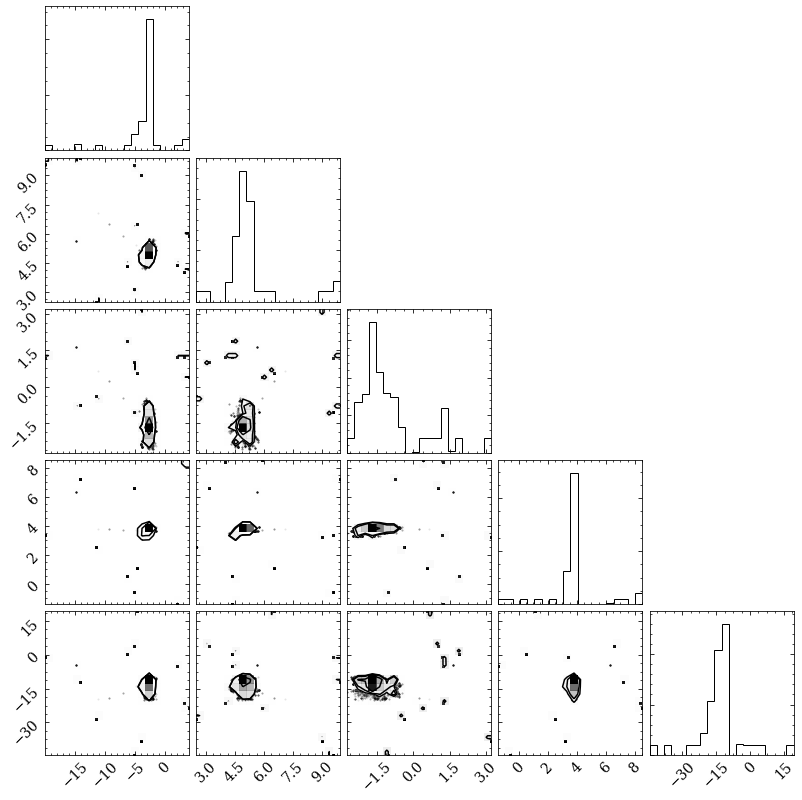

In [264]:
_=corner.corner(samples)

In [268]:
# save the samples of the covariance hyperparameters
np.save('output_data/')

((-6.907755278982137,
  4.382026634673881,
  0.0,
  3.6888794541139363,
  -11.512925464970229),
 array([ -7.90775528,   3.38202663,  -1.        ,   2.68887945,
        -12.51292546]))

In [267]:
np.log(1e-6)

-13.815510557964274